In [1]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import random
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import matplotlib.pyplot as plt
import pprint

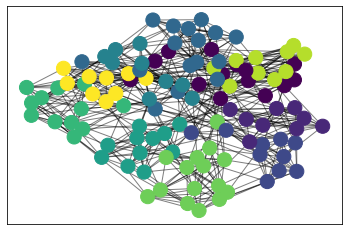

In [2]:
G=nx.Graph()
# gr=pd.read_csv('karate.csv')
#gr=pd.read_csv('dolphin.csv')
gr=pd.read_csv('football.csv')
edge=[(gr['Source'][i],gr['Destination'][i]) for i in range(0,len(gr['Source']))]
G.add_edges_from(edge)
node=max([max(x[0],x[1]) for x in edge])
# compute the best partition
# partition contains color of each node
partition = community_louvain.best_partition(G)

# visualization of clusters
pos = nx.spring_layout(G)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=200,cmap=cmap, node_color=list(partition.values()),)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [3]:
# Generating gateEdges
# gateEdges contains edges--> [(a,b),(b,c)]
gateEdges=[]
for x in edge:
    if(partition[x[0]]!=partition[x[1]]):
        gateEdges.append(x)

# Generating gate nodes 
gateNodesDict={}

for tup in gateEdges:
    gateNodesDict[tup[0]]=1
    gateNodesDict[tup[1]]=1

gateNodesList=list(gateNodesDict.keys())

print("Gateway graph nodes:",gateNodesList)
for x in gateNodesList:
    for y in gateNodesList:
        if(x==y or ((x,y) in gateEdges) or ((y,x) in gateEdges)):
            continue
        else:
            if(partition[x]==partition[y]):
                if((x,y) in edge or (y,x) in edge):
                    gateEdges.append((x,y))

Gateway graph nodes: [1, 2, 34, 36, 66, 28, 58, 102, 3, 4, 15, 73, 75, 12, 27, 59, 5, 6, 109, 91, 98, 7, 8, 56, 86, 41, 74, 83, 9, 10, 42, 23, 65, 11, 61, 13, 14, 18, 46, 111, 16, 69, 93, 115, 17, 39, 68, 82, 19, 20, 37, 45, 21, 22, 76, 33, 47, 24, 48, 79, 112, 25, 26, 67, 85, 88, 54, 107, 29, 114, 30, 43, 92, 31, 51, 110, 32, 80, 50, 35, 95, 38, 60, 81, 96, 40, 55, 52, 64, 44, 71, 63, 62, 49, 97, 99, 53, 113, 87, 90, 57, 89, 72, 106, 77, 105, 70, 84, 104, 78, 108, 94, 101, 100, 103]


In [4]:
# Gate graph
# This is the gate way graph
# gate
tot_g=[]
for i in range(0,500):
    g = G
    attr = {(u, v): {"weight": round(random.uniform(0,1),2)} for (u, v) in G.edges()}
    nx.set_edge_attributes(g, attr)
    tot_g.append(g)

for k in range(0,500):
    tot_g[k].add_nodes_from(gateNodesList)
    for i in range(0,len(gateEdges)):
        tot_g[k].add_edge(gateEdges[i][0],gateEdges[i][1],weight=round(random.uniform(0,1),2))

In [5]:
#BCS Score
def BCS(gg,nodes):
    BCS_=[0]*(nodes+1)
    for i in gg:
        x=(nx.betweenness_centrality(i,weight='weight'))
        #print(x)
        for j in x:
            BCS_[j]+=(1/10)*x[j]
    #BCS_=[round(i,3) for i in BCS_]
    return BCS_
BCSSS=BCS(tot_g,max([max(a[0],a[1]) for a in gateEdges]))
BCS_value={}
for i in range(1,max([max(a[0],a[1]) for a in gateEdges])+1):
    BCS_value[i]=BCSSS[i]
BCS_value=(sorted(BCS_value.items(), key=lambda x: x[1],reverse=True))
print(BCS_value)

[(98, 10.811597578015862), (99, 10.444159809553435), (78, 9.1943538787973), (12, 8.088806086011559), (74, 6.21991926719456), (58, 5.125368731563419), (25, 4.642136314236869), (49, 4.638901826838463), (88, 4.323215856750998), (57, 4.12979351032444), (45, 3.939605651296366), (22, 3.702841173730768), (59, 3.605159654298024), (55, 3.5191222894995255), (87, 3.4977746726698737), (54, 3.471898773482358), (48, 3.3942710759198795), (56, 3.3787455364073806), (18, 3.2267246286808398), (21, 3.220255653883998), (76, 3.184029395021448), (43, 3.141981058841782), (66, 3.060471976401153), (89, 3.024245717538677), (105, 3.0132484603839815), (81, 3.006132588107445), (33, 2.911038658593381), (16, 2.7363763390777662), (8, 2.7279666718418345), (109, 2.6050561507012335), (113, 2.5972933809449885), (2, 2.592118201107495), (1, 2.5131967085856295), (107, 2.497024271593441), (20, 2.4963773741137714), (93, 2.4588573202918727), (63, 2.4316876261449907), (52, 2.4051648294778336), (62, 2.355353723541897), (77, 2.280

In [6]:
# Model selection - diffusion time
model = ep.SIModel(G)

# Model Configuration
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.03)
cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in edge]))
model.set_initial_status(cfg)

# Simulation execution
iterations = model.iteration_bunch(200)

#Mapping diffusion_time_to_each_node
time_of_diffusion={}
for i in range(1,node+1):
    time_of_diffusion[i]=-1
for i in iterations:
    for j in i['status']:
        if(i['status'][j]==1):
            time_of_diffusion[j]=i['iteration']

100%|██████████| 200/200 [00:00<00:00, 1526.74it/s]


In [7]:
print(time_of_diffusion)

{1: 12, 2: 16, 3: 31, 4: 30, 5: 9, 6: 21, 7: 26, 8: 15, 9: 18, 10: 7, 11: 38, 12: 38, 13: 29, 14: 26, 15: 36, 16: 33, 17: 18, 18: 23, 19: 31, 20: 28, 21: 27, 22: 16, 23: 7, 24: 15, 25: 15, 26: 23, 27: 35, 28: 25, 29: 16, 30: 37, 31: 25, 32: 32, 33: 21, 34: 29, 35: 30, 36: 27, 37: 26, 38: 17, 39: 28, 40: 34, 41: 35, 42: 19, 43: 33, 44: 31, 45: 31, 46: 23, 47: 15, 48: 14, 49: 21, 50: 18, 51: 21, 52: 0, 53: 31, 54: 18, 55: 39, 56: 25, 57: 25, 58: 20, 59: 22, 60: 32, 61: 36, 62: 28, 63: 16, 64: 34, 65: 33, 66: 24, 67: 26, 68: 17, 69: 14, 70: 13, 71: 22, 72: 36, 73: 31, 74: 16, 75: 28, 76: 24, 77: 25, 78: 8, 79: 1, 80: 29, 81: 26, 82: 25, 83: 26, 84: 16, 85: 26, 86: 46, 87: 23, 88: 25, 89: 15, 90: 18, 91: 14, 92: 22, 93: 26, 94: 22, 95: 26, 96: 15, 97: 29, 98: 31, 99: 30, 100: 34, 101: 27, 102: 26, 103: 38, 104: 26, 105: 17, 106: 27, 107: 38, 108: 29, 109: 6, 110: 26, 111: 17, 112: 7, 113: 31, 114: 31, 115: 23}


In [8]:
sensor_nodes=[BCS_value[i][0] for i in range(0,3)]
print(sensor_nodes)
print(gateNodesList)
print(len(gateEdges))

[98, 99, 78]
[1, 2, 34, 36, 66, 28, 58, 102, 3, 4, 15, 73, 75, 12, 27, 59, 5, 6, 109, 91, 98, 7, 8, 56, 86, 41, 74, 83, 9, 10, 42, 23, 65, 11, 61, 13, 14, 18, 46, 111, 16, 69, 93, 115, 17, 39, 68, 82, 19, 20, 37, 45, 21, 22, 76, 33, 47, 24, 48, 79, 112, 25, 26, 67, 85, 88, 54, 107, 29, 114, 30, 43, 92, 31, 51, 110, 32, 80, 50, 35, 95, 38, 60, 81, 96, 40, 55, 52, 64, 44, 71, 63, 62, 49, 97, 99, 53, 113, 87, 90, 57, 89, 72, 106, 77, 105, 70, 84, 104, 78, 108, 94, 101, 100, 103]
792


In [9]:
delta_t=[]
min_v=min([time_of_diffusion[i] for i in sensor_nodes])
min_n=-1
for i in sensor_nodes:
    if(time_of_diffusion[i]==min_v):
        min_n=i
        break
delta_t=[abs(time_of_diffusion[i]-min_v) for i in sensor_nodes if(i!=min_n)]
print(delta_t)

[23, 22]


In [10]:
timeOfDiffusions=[]
for i in tot_g:
    print(len(i.edges()))
    # Model selection - diffusion time
    model = ep.SIModel(i)

    # Model Configuration
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', 0.03)
    cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in edge]))
    model.set_initial_status(cfg)

    # Simulation execution
    iterations = model.iteration_bunch(200)

    #Mapping diffusion_time_to_each_node
    time_of_diffusion={}
    for i in range(1,node+1):
        time_of_diffusion[i]=-1
    for i in iterations:
        for j in i['status']:
            if(i['status'][j]==1):
                time_of_diffusion[j]=i['iteration']
    timeOfDiffusions.append(len(time_of_diffusion))

  0%|          | 0/200 [00:00<?, ?it/s]

613


  0%|          | 0/200 [00:00<?, ?it/s]

613


 91%|█████████ | 182/200 [00:00<00:00, 1819.90it/s]

613


 96%|█████████▌| 192/200 [00:00<00:00, 1901.60it/s]

613


  0%|          | 0/200 [00:00<?, ?it/s]

613


  0%|          | 0/200 [00:00<?, ?it/s]

613


  0%|          | 0/200 [00:00<?, ?it/s]

613


  0%|          | 0/200 [00:00<?, ?it/s]

613


  0%|          | 0/200 [00:00<?, ?it/s]

613


  0%|          | 0/200 [00:00<?, ?it/s]

613


  0%|          | 0/200 [00:00<?, ?it/s]

613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 70%|██████▉   | 139/200 [00:00<00:00, 1389.79it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 90%|████████▉ | 179/200 [00:00<00:00, 1772.72it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 96%|█████████▌| 192/200 [00:00<00:00, 1919.61it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 30%|███       | 60/200 [00:00<00:00, 594.05it/s]

613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 75%|███████▌  | 150/200 [00:00<00:00, 689.78it/s]

613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 46%|████▌     | 91/200 [00:00<00:00, 909.95it/s]

613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 89%|████████▉ | 178/200 [00:00<00:00, 1762.45it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 87%|████████▋ | 174/200 [00:00<00:00, 1722.84it/s]

613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 92%|█████████▏| 184/200 [00:00<00:00, 1821.90it/s]

613
613


 92%|█████████▏| 183/200 [00:00<00:00, 1829.63it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 93%|█████████▎| 186/200 [00:00<00:00, 1859.77it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 92%|█████████▏| 184/200 [00:00<00:00, 1821.92it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 55%|█████▍    | 109/200 [00:00<00:00, 1079.26it/s]

613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 72%|███████▏  | 143/200 [00:00<00:00, 1415.89it/s]

613
613


 40%|████      | 81/200 [00:00<00:00, 802.00it/s]

613


 11%|█         | 22/200 [00:00<00:00, 217.79it/s]

613


 32%|███▏      | 64/200 [00:00<00:00, 633.68it/s]

613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 94%|█████████▍| 188/200 [00:00<00:00, 1880.00it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 97%|█████████▋| 194/200 [00:00<00:00, 1939.47it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 86%|████████▌ | 172/200 [00:00<00:00, 1719.96it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 80%|████████  | 160/200 [00:00<00:00, 1599.97it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 87%|████████▋ | 174/200 [00:00<00:00, 1723.17it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 88%|████████▊ | 177/200 [00:00<00:00, 1753.06it/s]

613
613


 89%|████████▉ | 178/200 [00:00<00:00, 1779.84it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 91%|█████████ | 182/200 [00:00<00:00, 1802.09it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


100%|█████████▉| 199/200 [00:00<00:00, 993.93it/s] 

613


 57%|█████▊    | 115/200 [00:00<00:00, 1138.64it/s]

613


 34%|███▎      | 67/200 [00:00<00:00, 669.98it/s]

613


 24%|██▍       | 48/200 [00:00<00:00, 475.28it/s]

613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


100%|██████████| 200/200 [00:00<00:00, 1197.60it/s]


613
613


100%|██████████| 200/200 [00:00<00:00, 1176.47it/s]


613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 42%|████▎     | 85/200 [00:00<00:00, 849.96it/s]

613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 84%|████████▍ | 169/200 [00:00<00:00, 1689.95it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 54%|█████▍    | 108/200 [00:00<00:00, 1069.21it/s]

613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 82%|████████▎ | 165/200 [00:00<00:00, 1633.75it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 95%|█████████▌| 190/200 [00:00<00:00, 1881.30it/s]

613
613


 92%|█████████▏| 184/200 [00:00<00:00, 1839.96it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 55%|█████▍    | 109/200 [00:00<00:00, 1089.91it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 94%|█████████▍| 188/200 [00:00<00:00, 1879.60it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 89%|████████▉ | 178/200 [00:00<00:00, 1779.95it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 89%|████████▉ | 178/200 [00:00<00:00, 1779.84it/s]

613
613


 51%|█████     | 102/200 [00:00<00:00, 1019.92it/s]

613


 94%|█████████▎| 187/200 [00:00<00:00, 1851.64it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


100%|██████████| 200/200 [00:00<00:00, 1219.51it/s]

613
613


 24%|██▍       | 48/200 [00:00<00:00, 475.30it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 37%|███▋      | 74/200 [00:00<00:00, 732.65it/s]

613


 46%|████▌     | 91/200 [00:00<00:00, 901.00it/s]

613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 50%|█████     | 101/200 [00:00<00:00, 1000.06it/s]

613


 40%|████      | 81/200 [00:00<00:00, 802.02it/s]

613


 59%|█████▉    | 118/200 [00:00<00:00, 1168.32it/s]

613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 47%|████▋     | 94/200 [00:00<00:00, 930.73it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 56%|█████▌    | 111/200 [00:00<00:00, 533.99it/s]

613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 36%|███▌      | 72/200 [00:00<00:00, 712.86it/s]

613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 38%|███▊      | 75/200 [00:00<00:00, 742.64it/s]

613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 49%|████▉     | 98/200 [00:00<00:00, 970.28it/s]

613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 98%|█████████▊| 197/200 [00:00<00:00, 1950.52it/s]

613
613


 93%|█████████▎| 186/200 [00:00<00:00, 1841.70it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 87%|████████▋ | 174/200 [00:00<00:00, 1739.74it/s]

613
613


 92%|█████████▏| 183/200 [00:00<00:00, 1829.61it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 95%|█████████▌| 190/200 [00:00<00:00, 1899.93it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


 86%|████████▋ | 173/200 [00:00<00:00, 1713.15it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


  0%|          | 0/200 [00:00<?, ?it/s]

613
613


100%|██████████| 200/200 [00:00<00:00, 1470.83it/s]

613


In [11]:
for i in timeOfDiffusions:
    print(i)
print(len(gateNodesList))

115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115
115


792


100%|██████████| 200/200 [00:00<00:00, 1111.07it/s]


100%|██████████| 200/200 [00:00<00:00, 769.23it/s]


100%|██████████| 200/200 [00:00<00:00, 1105.00it/s]


100%|██████████| 200/200 [00:00<00:00, 1087.12it/s]


100%|██████████| 200/200 [00:00<00:00, 843.88it/s]


100%|██████████| 200/200 [00:00<00:00, 909.06it/s]


100%|██████████| 200/200 [00:00<00:00, 1117.36it/s]


100%|██████████| 200/200 [00:00<00:00, 966.19it/s] 


100%|██████████| 200/200 [00:00<00:00, 1086.90it/s]


100%|██████████| 200/200 [00:00<00:00, 1086.67it/s]


100%|██████████| 200/200 [00:00<00:00, 1123.59it/s]


100%|██████████| 200/200 [00:00<00:00, 1105.00it/s]


100%|██████████| 200/200 [00:00<00:00, 510.21it/s]


100%|██████████| 200/200 [00:00<00:00, 913.27it/s]


100%|██████████| 200/200 [00:00<00:00, 809.74it/s]


[[2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 8.371615527564551e-48, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101], [2.889531540864567e-101, 2.1162918624254238e-09, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 1.1052413972504248e-206, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101], [2.889531540864567e-101, 2.88953154

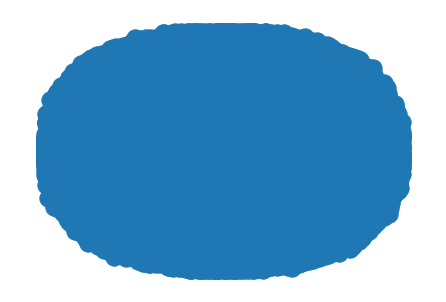

In [12]:
g__ = nx.Graph()
g__.add_edges_from(gateEdges)
print(len(gateEdges))
allDiffusionTime = []
mcaps=[tot_g[i] for i in random.sample(range(0, 500), 20)]
toTakeArgmax=[]
for node in gateNodesList:
#     print(node)
    bfs_tree = nx.bfs_tree(g__, source = node)
    nx.draw(bfs_tree)
    vecOfArgmax=[]
    for mcap in mcaps:
        model = ep.SIModel(bfs_tree)
        # Model Configuration
        cfg = mc.Configuration()
        cfg.add_model_parameter('beta', 0.03)
        cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in bfs_tree.edges()]))
        model.set_initial_status(cfg)

        # Simulation execution
        iterations = model.iteration_bunch(200)

        #Mapping diffusion_time_to_each_node
        
        time_of_diffusion={}
        for i in range(1,node+1):
            time_of_diffusion[i]=-1
        for i in iterations:
            for j in i['status']:
                if(i['status'][j]==1):
                    time_of_diffusion[j]=i['iteration']
        allDiffusionTime.append(time_of_diffusion)
        
        for node in gateNodesList:
            if node not in time_of_diffusion.keys(): 
                time_of_diffusion[node]=-1
        
        min_v=min([time_of_diffusion[i] for i in sensor_nodes])
        min_n=-1
        for i in sensor_nodes:
            if(time_of_diffusion[i]==min_v):
                min_n=i
                break
        mu=[abs(time_of_diffusion[i]+min_v)/2 for i in sensor_nodes if(i!=min_n)]
#         print(len(delta_t),len(mu))
        
        arrivals=[]
        
        for sensor in sensor_nodes:
            if(time_of_diffusion[sensor]==-1):
                arrivals.append(200)
            else:
                arrivals.append(time_of_diffusion[sensor])
                
#         print("arrivals",arrivals)
                
        new_delta_ts = []
            
        for i in range(0,len(arrivals)):
            new_delta_t=[]
            for j in range(0,len(arrivals)):
                if(i!=j):
                    new_delta_t.append(abs(arrivals[j]-arrivals[i]))
            new_delta_ts.append(new_delta_t)
#             print("new_delta_ts",new_delta_ts)
#         print(new_delta_ts)
            
        lambd = []
        for i in range(0,len(new_delta_ts)-1):
#             print("---> ",len(new_delta_ts[i]),len(new_delta_ts[i+1]))
            val = np.correlate(new_delta_ts[i],new_delta_ts[i+1],"same")
            for i in range(0,len(val)):
                if (val[i]==0):
                    val[i]=1
            lambd.append(val)
#         print("lambd",lambd)
#         print("delta_t",delta_t,"mu",mu)    
        sub = np.subtract(delta_t,mu)
#         print("sub",sub)
        lambd[0][1]=0
        powerOfe = np.dot(np.dot((sub), np.linalg.inv(lambd) ),np.transpose(sub))
#         print("powerOfe",powerOfe)
        powerOfe=abs(powerOfe)
        fun = (1/np.linalg.det(lambd))*np.exp(-(1/2)*powerOfe)
        vecOfArgmax.append(fun)
    toTakeArgmax.append(vecOfArgmax)
print(toTakeArgmax)
#     print(node)
# nx.draw(nx.bfs_tree(g, source = 5))
#     print(time_of_diffusion)

In [13]:
print(allDiffusionTime)

[{1: -1, 50: 0, 2: -1, 34: -1, 36: -1, 66: -1, 28: -1, 58: -1, 102: -1, 3: -1, 4: -1, 15: -1, 73: -1, 75: -1, 12: -1, 27: -1, 59: -1, 5: -1, 6: -1, 109: -1, 91: -1, 98: -1, 7: -1, 8: -1, 56: -1, 86: -1, 41: -1, 74: -1, 83: -1, 9: -1, 10: -1, 42: -1, 23: -1, 65: -1, 11: -1, 61: -1, 13: -1, 14: -1, 18: -1, 46: -1, 111: -1, 16: -1, 69: -1, 93: -1, 115: -1, 17: -1, 39: -1, 68: -1, 82: -1, 19: -1, 20: -1, 37: -1, 45: -1, 21: -1, 22: -1, 76: -1, 33: -1, 47: -1, 24: -1, 48: -1, 79: -1, 112: -1, 25: -1, 26: -1, 67: -1, 85: -1, 88: -1, 54: -1, 107: -1, 29: -1, 114: -1, 30: -1, 43: -1, 92: -1, 31: -1, 51: -1, 110: -1, 32: -1, 80: -1, 35: -1, 95: -1, 38: -1, 60: -1, 81: -1, 96: -1, 40: -1, 55: -1, 52: -1, 64: -1, 44: -1, 71: -1, 63: -1, 62: -1, 49: -1, 97: -1, 99: -1, 53: -1, 113: -1, 87: -1, 90: -1, 57: -1, 89: -1, 72: -1, 106: -1, 77: -1, 105: -1, 70: -1, 84: -1, 104: -1, 78: -1, 108: -1, 94: -1, 101: -1, 100: -1, 103: -1}, {1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1, 10: -1,

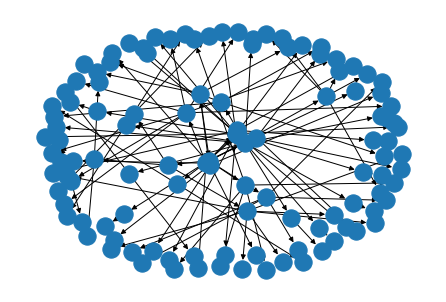

In [14]:
nx.draw(nx.bfs_tree(g, source = 5))

In [15]:
print(len(toTakeArgmax[0]),len(toTakeArgmax))

20 115


In [16]:
finArg = np.argmax(toTakeArgmax,axis=1)

In [17]:
id=-1
mx=-1
for i in range(0,len(finArg)):
    if(toTakeArgmax[i][finArg[i]]>mx):
        mx=toTakeArgmax[i][finArg[i]]
        id=i
clusterNode=gateNodesList[id]

In [18]:
print(clusterNode)

112


In [19]:
partition[clusterNode]
color=partition[clusterNode]
print(partition[clusterNode])

8


In [35]:
print(partition[52])

8


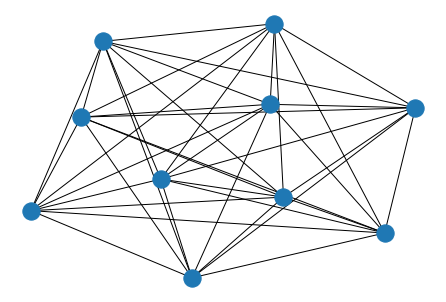

In [21]:
candidateCluster=[]
for e in G.edges():
    if(partition[e[0]]==color and partition[e[1]]==color):
        candidateCluster.append(e)
candidateGraph = nx.Graph()
candidateGraph.add_edges_from(candidateCluster)
nx.draw(candidateGraph)

In [22]:
myset=set([])
for e in candidateCluster:
    myset.add(e[0])
    myset.add(e[1])
print(myset)
my=[]
for ele in myset:
    my.append(ele)
print("list",my)


{69, 8, 9, 109, 78, 79, 112, 52, 22, 23}
list [69, 8, 9, 109, 78, 79, 112, 52, 22, 23]


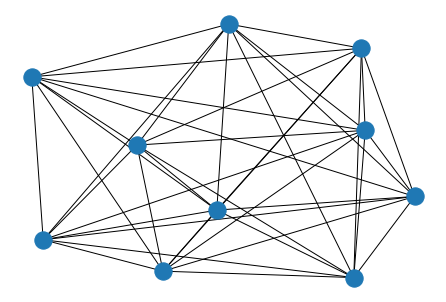

In [23]:
cG = G.subgraph(my)
nx.draw(cG)

500


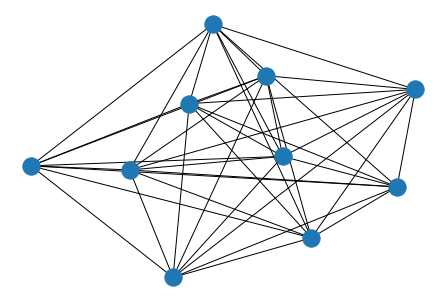

In [24]:
tot_cg_set=set([])
for i in range(0,500):
    tot_cg_set.add(tot_g[i].subgraph(my))
print(len(tot_cg_set))
tot_cg=[]
for g in tot_cg_set:
    tot_cg.append(g)
# print(len(tot_cg))
nx.draw(tot_g[7].subgraph(my))

In [25]:
print(len(cG.edges()))
nodes_in_cg=[]
nodes_in_cg_set=set([])
for ee in cG.edges():
    nodes_in_cg_set.add(ee[0])
    nodes_in_cg_set.add(ee[1])
for ele in nodes_in_cg_set:
    nodes_in_cg.append(ele)
print("nodes_in_cg",nodes_in_cg)
BCSSS_cg=BCS(tot_cg,len(tot_cg)+2)
print(BCSSS_cg)
BCS_value_cg={}
for i in range(1,max([max(a[0],a[1]) for a in cG.edges()])+1):
    BCS_value_cg[i]=BCSSS_cg[i]
BCS_value_cg=(sorted(BCS_value_cg.items(), key=lambda x: x[1],reverse=True))
print(BCS_value_cg)

40
nodes_in_cg [69, 8, 9, 109, 78, 79, 112, 52, 22, 23]
[0, 0, 0, 0, 0, 0, 0, 0, 9.722222222222245, 6.944444444444516, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.3888888888888846, 12.50000000000011, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8.333333333333327, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8.333333333333327, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12.50000000000011, 0, 0, 1.3888888888888846, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [26]:
# Model selection - diffusion time
model = ep.SIModel(cG)

# Model Configuration
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.03)
cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in cG.edges()]))
model.set_initial_status(cfg)

# Simulation execution
iterations = model.iteration_bunch(200)

#Mapping diffusion_time_to_each_node
time_of_diffusion_cg={}
for i in range(1,node+1):
    time_of_diffusion_cg[i]=-1
for i in iterations:
    for j in i['status']:
        if(i['status'][j]==1):
            time_of_diffusion_cg[j]=i['iteration']

C:\Users\new user\anaconda3\lib\site-packages\ndlib\models\DiffusionModel.py:170: UserWarning: The fraction_infected value is too low given the number of nodes of the selected graph: a single node will be set as infected
  "The fraction_infected value is too low given the number of nodes of the selected graph: a "
100%|██████████| 200/200 [00:00<00:00, 2898.40it/s]


In [27]:
print(time_of_diffusion_cg)

{1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: -1, 7: -1, 8: 15, 9: 11, 10: -1, 11: -1, 12: -1, 13: -1, 14: -1, 15: -1, 16: -1, 17: -1, 18: -1, 19: -1, 20: -1, 21: -1, 22: 13, 23: 19, 24: -1, 25: -1, 26: -1, 27: -1, 28: -1, 29: -1, 30: -1, 31: -1, 32: -1, 33: -1, 34: -1, 35: -1, 36: -1, 37: -1, 38: -1, 39: -1, 40: -1, 41: -1, 42: -1, 43: -1, 44: -1, 45: -1, 46: -1, 47: -1, 48: -1, 49: -1, 50: -1, 51: -1, 52: 21, 53: -1, 54: -1, 55: -1, 56: -1, 57: -1, 58: -1, 59: -1, 60: -1, 61: -1, 62: -1, 63: -1, 64: -1, 65: -1, 66: -1, 67: -1, 68: -1, 69: 16, 70: -1, 71: -1, 72: -1, 73: -1, 74: -1, 75: -1, 76: -1, 77: -1, 78: 4, 79: 13, 80: -1, 81: -1, 82: -1, 83: -1, 84: -1, 85: -1, 86: -1, 87: -1, 88: -1, 89: -1, 90: -1, 91: -1, 92: -1, 93: -1, 94: -1, 95: -1, 96: -1, 97: -1, 98: -1, 99: -1, 100: -1, 101: -1, 102: -1, 103: -1, 112: 0, 109: 21}


In [28]:
sensor_nodes_cg=[BCS_value_cg[i][0] for i in range(0,3)]
print(sensor_nodes_cg)

[23, 109, 8]


In [29]:
delta_t_cg=[]
min_v_cg=min([time_of_diffusion_cg[i] for i in sensor_nodes_cg])
min_n_cg=-1
for i in sensor_nodes_cg:
    if(time_of_diffusion_cg[i]==min_v_cg):
        min_n_cg=i
        break
delta_t_cg=[abs(time_of_diffusion_cg[i]-min_v_cg) for i in sensor_nodes_cg if(i!=min_n_cg)]
print(delta_t_cg)

[4, 6]


100%|██████████| 200/200 [00:00<00:00, 4080.70it/s]


100%|██████████| 200/200 [00:00<00:00, 5405.62it/s]


[[2.889531540864567e-101, 6.213019991395711e-10, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 6.213019991395711e-10, 2.933055496474633e-115, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.933055496474633e-115, 2.889531540864567e-101, 6.213019991395711e-10], [2.889531540864567e-101, 2.889531540864567e-101, 6.213019991395711e-10, 2.889531540864567e-101, 2.933055496474633e-115, 2.889531540864567e-101, 2.889531540864567e-101, 8.974929369121457e-07, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101, 6.213019991395711e-10, 2.889531540864567e-101, 6.213019991395711e-10, 1.651848661369304e-08, 2.889531540864567e-101, 2.889531540864567e-101, 2.889531540864567e-101], [3.060020400524259e-07, 2.889531540864567e-

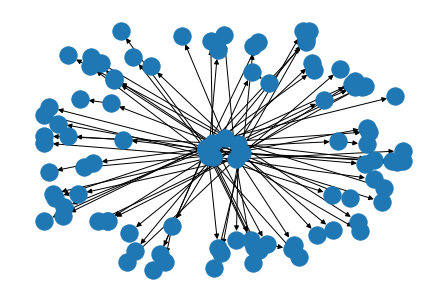

In [30]:
g___cg = nx.Graph()
g___cg.add_edges_from(cG.edges())
# allDiffusionTime = []
mcaps_cg=[tot_cg[i] for i in random.sample(range(0, 500), 20)]
toTakeArgmax_cg=[]
for node in nodes_in_cg:
#     print(node)
    bfs_tree = nx.bfs_tree(g___cg, source = node)
    nx.draw(bfs_tree)
    vecOfArgmax_cg=[]
    for mcap_cg in mcaps_cg:
        model = ep.SIModel(bfs_tree)
        # Model Configuration
        cfg = mc.Configuration()
        cfg.add_model_parameter('beta', 0.03)
        cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in bfs_tree.edges()]))
        model.set_initial_status(cfg)

        # Simulation execution
        iterations = model.iteration_bunch(200)

        #Mapping diffusion_time_to_each_node
        
        time_of_diffusion_cg={}
        for i in range(1,node+1):
            time_of_diffusion_cg[i]=-1
        for i in iterations:
            for j in i['status']:
                if(i['status'][j]==1):
                    time_of_diffusion_cg[j]=i['iteration']
        
        for node in nodes_in_cg:
            if node not in time_of_diffusion_cg.keys(): 
                time_of_diffusion_cg[node]=-1
        
        min_v_cg=min([time_of_diffusion_cg[i] for i in sensor_nodes_cg])
        min_n_cg=-1
        for i in sensor_nodes_cg:
            if(time_of_diffusion_cg[i]==min_v_cg):
                min_n_cg=i
                break
        mu_cg=[abs(time_of_diffusion_cg[i]+min_v_cg)/2 for i in sensor_nodes_cg if(i!=min_n_cg)]
#         print(len(delta_t_cg),len(mu_cg))
        
        arrivals_cg=[]
        
        for sensor in sensor_nodes_cg:
            if(time_of_diffusion_cg[sensor]==-1):
                arrivals_cg.append(200)
            else:
                arrivals_cg.append(time_of_diffusion_cg[sensor])
                
#         print("arrivals_cg",arrivals_cg)
                
        new_delta_ts_cg = []
            
        for i in range(0,len(arrivals_cg)):
            new_delta_t_cg=[]
            for j in range(0,len(arrivals_cg)):
                if(i!=j):
                    new_delta_t_cg.append(abs(arrivals_cg[j]-arrivals_cg[i]))
            new_delta_ts_cg.append(new_delta_t_cg)
#             print("new_delta_ts_cg",new_delta_ts_cg)
#         print(new_delta_ts_cg)
            
        lambd_cg = []
        for i in range(0,len(new_delta_ts_cg)-1):
#             print("---> ",len(new_delta_ts_cg[i]),len(new_delta_ts_cg[i+1]))
            val_cg = np.correlate(new_delta_ts_cg[i],new_delta_ts_cg[i+1],"same")
            for i in range(0,len(val_cg)):
                if (val_cg[i]==0):
                    val_cg[i]=1
            lambd_cg.append(val_cg)
#         print("lambd_cg",lambd_cg)
#         print("delta_t_cg",delta_t_cg,"mu_cg",mu_cg)    
        sub_cg = np.subtract(delta_t,mu_cg)
#         print("sub_cg",sub_cg)
        lambd_cg[0][1]=0
        powerOfe_cg = np.dot(np.dot((sub_cg), np.linalg.inv(lambd_cg) ),np.transpose(sub_cg))
#         print("powerOfe_cg",powerOfe_cg)
        powerOfe_cg=abs(powerOfe_cg)
        fun_cg = (1/np.linalg.det(lambd_cg))*np.exp(-(1/2)*powerOfe_cg)
        vecOfArgmax_cg.append(fun_cg)
    toTakeArgmax_cg.append(vecOfArgmax_cg)
print(toTakeArgmax_cg)
#     print(node)
# nx.draw(nx.bfs_tree(g, source = 5))
#     print(time_of_diffusion)

In [31]:
print(len(toTakeArgmax_cg[0]),len(toTakeArgmax_cg))

20 10


In [32]:
finArg_cg = np.argmax(toTakeArgmax_cg,axis=1)

In [33]:
id_cg=-1
mx_cg=-1
for i in range(0,len(finArg_cg)):
    if(toTakeArgmax_cg[i][finArg_cg[i]]>mx):
        mx_cg=toTakeArgmax_cg[i][finArg_cg[i]]
        id_cg=i
source_node=nodes_in_cg[id_cg]
print(source_node)

52


In [36]:
print(partition[source_node])
print(partition[52])

8
8
